# Graphene quantum Hall effect

In [1]:
import kwant
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
# A COMMENT TO 
# git add .
# git commit -m "message"
# git push

## Fundamental constants

In [2]:
h = 6.626069e-34  # Planck constant (Js)
h_reduced=h/(2*np.pi)                            ##With h_reduced oom larger and Bmax=30, it works perfectly
## Scaling factor of 10 required --> h_reduced normal, Bmax=3
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)

print(h_reduced)

1.0545716346179718e-34


### Scaling

In [3]:
asquare = 1e-9 # [m] a is the lattice parameter
tsquare = 1 # [eV] t is the hopping parameter

scaling = 4 # scaling factor

"""scaling"""

a = asquare * scaling
t = tsquare / scaling

### Geometrical parameters

In [4]:
W=200e-9 ; L = 1000e-9 # width and length of the electronic system

## For width smaller than 50 nm, the script does not work since the magnetic length is 30 nm so wf start to overlap (?)
## Also for width slightly larger than that, the steps in the Hall resistance are lost. For w=200 nm they are recovered.
length_lead=20e-9                                         
posL = 350e-9 # pos of the leads along x
lead_ext = posL + length_lead/2
lead_int = posL - length_lead/2

flag=0

#### Geometry of the device

In [5]:
def geom(pos):
    x, y = pos
    
    if -L/2 < x < L/2 and -W/2 < y < W/2:
        return True
    else:
        return False

#### Geometry of the leads

In [6]:
def lead_shape(pos):
    x, y = pos
    
    return -W/2 < y < W/2

def lead_shape_left(pos):
    x, y = pos
    
    return -lead_ext < x < -lead_int

def lead_shape_right(pos):
    x, y = pos
    
    return lead_ext > x > lead_int

#### Defining onsite and hopping parameters

In [7]:
def onsite(site):
    """
    Definition of the potential. To reach the bottom of the conduction band, the potential is set at 4*t.
    A zone of potential Vg (above the bottom of the conduction band) can be defined in a given zone 
    (square or circle here). 
    
    """
    x, y = site.pos
    
    #Theoretically we should insert the tip potential here (?)
    #For now we set Vg=0
    
    rho = np.sqrt(x**2 + y**2)
    
    in_shape_1 = abs(x) < l_pot_2 and y > -W/2 + w_pot
    in_shape_2 = abs(x) < l_pot_3 and y > -W/2 + w_pot
    
    if in_shape_1:
        
        pot=0 + Vg + delta + disorder(site)
        return pot
    
    if in_shape_2:
        
        pot=0 + Vg + 2*delta + disorder(site)
        return pot
    
    else:
        
        pot=0+disorder(site)
        return pot

#### Disorder potential

In [8]:
def disorder(pos):
    x, y = pos
    
   
    
    #pot=0.05*random.uniform(0,t)
    pot=0
    
    if (pot!=0):
        flag=1
        
    
    return pot

Introducing a disorder of 0.01 leads to peaks in longitudinal resistance but we retain anyway plateaus in Hall resistance.

#### Hopping parameter

In [9]:
def hopping(site_i, site_j):   
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    
    

    """ Change the definition of hop to include the magnetic field Bfield in the definition of the hopping parameter """
    
    hop = t*np.exp(-1j*e*Bfield*(yi+yj)*(xj-xi)/(2*h_reduced))  # to be completed (as a function of Bfield) #I think there is a - in the exponent
    
    
    #print('Hopping parameter is ',hop)
    
    return hop

## Building the system

In [10]:
def sys_builder():
    lat = kwant.lattice.general([(np.sqrt(3)*a, 0), (0, 3*a)], [(a*np.sqrt(3)/2, 0), (0, a/2), (0, 3*a/2) 
                                                              , (a*np.sqrt(3)/2, 2*a)], norbs = 1)
    A, B, C, D = lat.sublattices
    
    


    
    sys=kwant.Builder()
    sys[lat.shape(geom, (0,0))]=onsite              #you assign to each site in lat.shape(geom, (0,0)) (all the lattice) the value onsite
    
    hoppings = (((0, 0), B, A), ((0, 0), C, B), ((0, 0), D, C), ((-1, 0), A, B), ((-1, 0), D, C), 
                ((0, 1), A, D)) # the function hopping is given on each edge
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping

    
    
  ### Schematic of the Hall bar ###

#   ,----------o----Vxx----.--------------.
#   |  Lead 3  |           |  Lead 5    __|__
#  Vxy     __|   |_______|   |__        '''''    (ground)
#   |               I
#   | Lead 1      ----->      Lead 2
#   |      __     _______     __
#   |        |   |       |   |
#   |  Lead 4  |               Lead 6
#   `----------'
    
    """ Lead 1 """
    sym0 = kwant.TranslationalSymmetry(lat.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[lat.shape(lead_shape, (0, 0))] = 0
    lead0[lat.neighbors()] = hopping

    """ Lead 2 """
    sym1 = kwant.TranslationalSymmetry(lat.vec((1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[lat.shape(lead_shape, (0, 0))] = 0    
    lead1[lat.neighbors()] = hopping

    """ Lead 3 """
    sym2 = kwant.TranslationalSymmetry(lat.vec((0, 1)))
    lead2 = kwant.Builder(sym2)
    lead2[lat.shape(lead_shape_left, (-posL, 0))] = 0
    lead2[lat.neighbors()] = hopping

    """ Lead 4 """
    sym3 = kwant.TranslationalSymmetry(lat.vec((0, -1)))
    lead3 = kwant.Builder(sym3)
    lead3[lat.shape(lead_shape_left, (-posL, 0))] = 0
    lead3[lat.neighbors()] = hopping

    """ Lead 5 """                             #sym already created with the correct symmetry, you just need to put the correct position
    lead4 = kwant.Builder(sym2)
    lead4[lat.shape(lead_shape_right, (posL, 0))] = 0
    lead4[lat.neighbors()] = hopping
    
    """Lead 6"""
    lead5 = kwant.Builder(sym3)
    lead5[lat.shape(lead_shape_right, (posL,0))] = 0
    lead5[lat.neighbors()]= hopping
    
    """ The leads are attached """
    sys.attach_lead(lead0)
    sys.attach_lead(lead1)
    sys.attach_lead(lead2)
    sys.attach_lead(lead3)
    sys.attach_lead(lead4)
    sys.attach_lead(lead5)
 
    sys = sys.finalized()
    
    
    
    return sys

    

In [11]:
sys= sys_builder()

#### Plotting the system

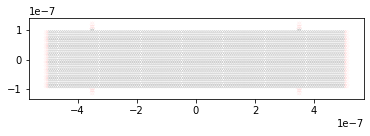

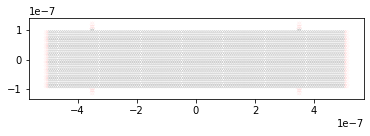

In [12]:
kwant.plot(sys, site_size = 1e-9)

## Electronic properties

In [13]:
Ef=-0.02 #maybe it could be modified
#Bfield=2*abs(Ef)**2*h_reduced/(9*t**2*a**2*e*0.2)   #The Fermi energy should be in between two LL
Bfield=1.82


""" Parameter for the zero density zone """  #these could be modified for the tip potential
Vg = -0.1
X_1=200e-9
X_2=300e-9
X_3=400e-9

l_pot=300e-9
l_pot_1=300e-9
l_pot_2=200e-9
l_pot_3=100e-9

delta=0.07
w_pot = 0


#print(Bfield)

params = dict(Bfield=Bfield, Vg = Vg) # params take the magnetic field as a parameter for the function hopping
print(params)



{'Bfield': 1.82, 'Vg': -0.1}


In [14]:
""" The wavelength must be (much more) larger than the lattice parameter """
""" We can also check the width of the device wrt the magnetic length, which is the extension of the wf"""
lambda_F = 3 * np.pi * t* a /abs(Ef) # computation of the wavelength
mag_length=np.sqrt(h_reduced/(e*Bfield))

print("lambda_F=", lambda_F);
print("l_b=", mag_length)

if lambda_F/a < 2:
    print('Warning : lambda_F must be larger than the lattice parameter a')
#if lambda_F > W/2:
#    print('Warning : lambda_F larger than half width of the bar')
if mag_length > W/2:
    print('Warning : wavefunctions extend across the whole bar')

lambda_F= 4.71238898038469e-07
l_b= 1.9018273689526035e-08


#### Visualization of the Landau levels

LL n 0 = 0.0
LL n 1 = 0.11154116184204041
LL n 2 = 0.1577430238398659
LL n 3 = 0.19319495944567694
LL n 4 = 0.22308232368408082
Fermi Energy = -0.02


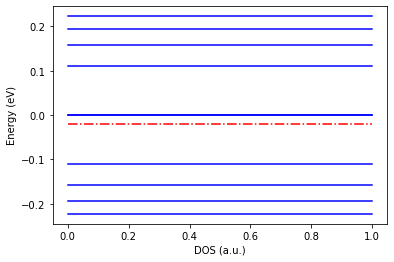

In [15]:
num_LL = 5

plt.figure()

for n in range(num_LL):
    
    """ 
    Change the definition of En to calculate the Landau levels energy as a function of
    the magnetic field Bfield and the Landau level label n
    
    """
    En_plus = 3*t*a*np.sqrt(e/(2*h_reduced))*np.sqrt(n*Bfield) # to be completed
    En_minus = -3*t*a*np.sqrt(e/(2*h_reduced))*np.sqrt(n*Bfield)
    
    x = np.array([0, 1]) ; 
    y_plus = En_plus*np.array([1, 1]) # in order to plot the Landau levels
    y_minus = En_minus*np.array([1, 1])
    plt.plot(x, y_plus, 'b')
    plt.plot(x, y_minus, 'b')
    
    print('LL n',n, '=',En_plus)
    
print ('Fermi Energy =',Ef)
    
plt.plot(x, Ef*np.array([1, 1]), 'r-.') # to plot the Fermi energy (in red)

plt.xlabel('DOS (a.u.)')
plt.ylabel('Energy (eV)')

plt.show()

#### Definition of the stairwell tip potential

Text(0, 0.5, 'Tip potential')

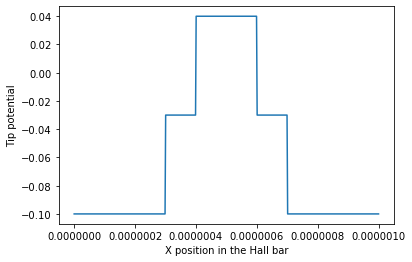

In [16]:

N=500;


plt.figure()
d=np.linspace(0,L,N)
potential =Vg*np.ones(N)


for i,X in enumerate(d):
     if (X > X_2 and X < L - X_2):
            potential[i]+=delta
            if (X > X_3 and X < L - X_3):
                potential[i]+=delta
                

        
plt.plot(d,potential)

plt.xlabel('X position in the Hall bar')
plt.ylabel('Tip potential')


#### Visualization of the LL + step potential

Vg =  -0.1
n 0 LL + pot = 0.1
n 0 LL + pot = 0.1
n 1 LL + pot = 0.21154116184204041
n -1 LL + pot = -0.011541161842040404
n 2 LL + pot = 0.2577430238398659
n -2 LL + pot = -0.057743023839865903
n 3 LL + pot = 0.293194959445677
n -3 LL + pot = -0.09319495944567693
n 4 LL + pot = 0.32308232368408085
n -4 LL + pot = -0.12308232368408081
Fermi Energy = -0.02


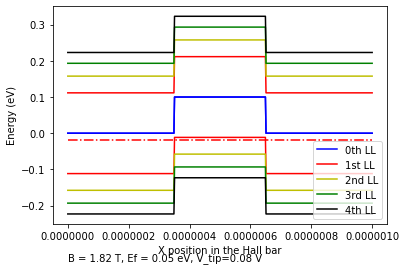

In [17]:


plt.figure()
d=np.linspace(0,L,N)

print('Vg = ',Vg)

LL_pot_plus = np.zeros(num_LL)
LL_pot_minus = np.zeros(num_LL)
En_plot_plus= np.zeros(num_LL)
En_plot_minus = np.zeros(num_LL)

for n in range(num_LL):
    
    """ 
    Change the definition of En to calculate the Landau levels energy as a function of
    the magnetic field Bfield and the Landau level label n
    
    """
    
    
    
    En_plus = 3*t*a*np.sqrt(e/(2*h_reduced))*np.sqrt(n*Bfield) # to be completed
    En_minus = -3*t*a*np.sqrt(e/(2*h_reduced))*np.sqrt(n*Bfield)
    
    LL_pot_plus[n]=En_plus-Vg
    LL_pot_minus[n]=En_minus-Vg
    En_plot_plus[n]=LL_pot_plus[n] + Vg
    En_plot_minus[n]=LL_pot_minus[n] + Vg
    
    En_plus_pot=np.zeros(N)
    En_minus_pot=np.zeros(N)
    
    print('n', n,  'LL + pot =', LL_pot_plus[n])
    print('n', -n, 'LL + pot =', LL_pot_minus[n])
    
    for i,X in enumerate(d):
        En_plus_pot[i] = En_plus
        En_minus_pot[i] = En_minus
        if (X > (L-l_pot)/2  and X< (L+l_pot)/2 ):
            En_plus_pot[i] = En_plus - Vg;
            En_minus_pot[i] = En_minus - Vg;
    
    if (n==0):
        plt.plot(d,En_plus_pot,'b', label = "0th LL") 
        plt.plot(d,En_minus_pot,'b')
    elif (n==1):
        plt.plot(d,En_plus_pot,'r', label = "1st LL")
        plt.plot(d,En_minus_pot,'r')
    elif (n==2):
        plt.plot(d,En_plus_pot,'y', label = "2nd LL")
        plt.plot(d,En_minus_pot,'y') 
    elif (n==3):
        plt.plot(d,En_plus_pot,'g', label = "3rd LL")
        plt.plot(d,En_minus_pot,'g')
    elif (n==4):
        plt.plot(d,En_plus_pot,'k', label = "4th LL")
        plt.plot(d,En_minus_pot,'k')
        
        
        
print ('Fermi Energy =',Ef)
    
plt.plot(d, Ef*np.ones(N), 'r-.') # to plot the Fermi energy (in red)

plt.xlabel('X position in the Hall bar')
plt.ylabel('Energy (eV)')

plt.text(0, -0.35, "B = 1.82 T, Ef = 0.05 eV, V_tip=0.08 V")

plt.legend(loc ="lower right")
plt.show()




#### Visualization of the LL + stairwell potential

LL n.  0
For X <  3e-07 and X >  7e-07 E = 0.1
For X <  4e-07 and X >  6e-07 E = 0.03
For X >  4e-07 and X <  6e-07 E = -0.04000000000000001
LL n.  0
For X <  3e-07 and X >  7e-07 E = 0.1
For X <  4e-07 and X >  6e-07 E = 0.03
For X >  4e-07 and X <  6e-07 E = -0.04000000000000001
LL n.  0
For X <  3e-07 and X >  7e-07 E = 0.1
For X <  4e-07 and X >  6e-07 E = 0.03
For X >  4e-07 and X <  6e-07 E = -0.04000000000000001
LL n.  1
For X <  3e-07 and X >  7e-07 E = 0.21154116184204041
For X <  4e-07 and X >  6e-07 E = 0.1415411618420404
For X >  4e-07 and X <  6e-07 E = 0.0715411618420404
LL n.  -1
For X <  3e-07 and X >  7e-07 E = -0.011541161842040404
For X <  4e-07 and X >  6e-07 E = -0.08154116184204041
For X >  4e-07 and X <  6e-07 E = -0.15154116184204042
LL n.  2
For X <  3e-07 and X >  7e-07 E = 0.2577430238398659
For X <  4e-07 and X >  6e-07 E = 0.1877430238398659
For X >  4e-07 and X <  6e-07 E = 0.1177430238398659
LL n.  -2
For X <  3e-07 and X >  7e-07 E = -0.05774302383986590

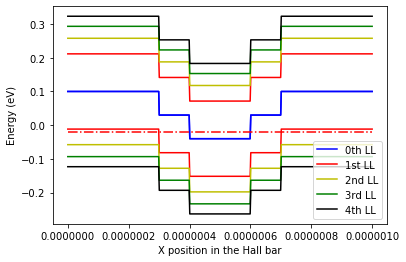

In [18]:

N=500;

modified_LL=np.zeros([9,3])        # The first index is the LL, the second the different well due to the stairwell potential

for n in range (num_LL):

     
    En_plus = 3*t*a*np.sqrt(e/(2*h_reduced))*np.sqrt(n*Bfield) # to be completed
    En_minus = -3*t*a*np.sqrt(e/(2*h_reduced))*np.sqrt(n*Bfield)
    
    
    En_plus_pot= En_plus-potential
    En_minus_pot=En_minus-potential
    
    
    
    
    if (n==0):
        plt.plot(d,En_plus_pot,'b', label = "0th LL") 
        plt.plot(d,En_minus_pot,'b')
    elif (n==1):
        plt.plot(d,En_plus_pot,'r', label = "1st LL")
        plt.plot(d,En_minus_pot,'r')
    elif (n==2):
        plt.plot(d,En_plus_pot,'y', label = "2nd LL")
        plt.plot(d,En_minus_pot,'y') 
    elif (n==3):
        plt.plot(d,En_plus_pot,'g', label = "3rd LL")
        plt.plot(d,En_minus_pot,'g')
    elif (n==4):
        plt.plot(d,En_plus_pot,'k', label = "4th LL")
        plt.plot(d,En_minus_pot,'k')
        
    if (n==0):
        modified_LL[n,0]=En_plus-Vg
        modified_LL[n,1]=En_plus-Vg-delta
        modified_LL[n,2]=En_plus-Vg-2*delta
        
        print('LL n. ', n)
        print('For X < ',X_2, 'and X > ',L-X_2, 'E =', modified_LL[n,0])
        print('For X < ',X_3, 'and X > ',L-X_3, 'E =', modified_LL[n,1])
        print('For X > ',X_3, 'and X < ',L-X_3, 'E =', modified_LL[n,2])
    
    
    modified_LL[2*n-1,0]=En_plus-Vg
    modified_LL[2*n-1,1]=En_plus-Vg-delta
    modified_LL[2*n-1,2]=En_plus-Vg-2*delta
    
    modified_LL[2*n,0]=En_minus-Vg
    modified_LL[2*n,1]=En_minus-Vg-delta
    modified_LL[2*n,2]=En_minus-Vg-2*delta
    
    
    print('LL n. ', n)
    print('For X < ',X_2, 'and X > ',L-X_2, 'E =', modified_LL[2*n-1,0])
    print('For X < ',X_3, 'and X > ',L-X_3, 'E =', modified_LL[2*n-1,1])
    print('For X > ',X_3, 'and X < ',L-X_3, 'E =', modified_LL[2*n-1,2])
        
   
    print('LL n. ', -n)
    print('For X < ',X_2, 'and X > ',L-X_2, 'E =', modified_LL[2*n,0])
    print('For X < ',X_3, 'and X > ',L-X_3, 'E =', modified_LL[2*n,1])
    print('For X > ',X_3, 'and X < ',L-X_3, 'E =', modified_LL[2*n,2])
        
    
plt.plot(d, Ef*np.ones(N), 'r-.') 
print('Fermi energy = ',Ef)

plt.xlabel('X position in the Hall bar')
plt.ylabel('Energy (eV)')


plt.legend(loc ="lower right")
plt.show()
        


### Current and wf density

#### Wave function

In [19]:
wfs = kwant.wave_function(sys, energy=Ef, params = params ) # the wave function is obtained by giving the 
                                                    # parameters in arguments
scattering_wf = wfs(0) # all scattering wave functions from lead 0

print(scattering_wf)

[[-1.89643162e-01-1.69593877e-01j -5.34444651e-01-4.78108867e-01j
  -6.77886927e-01-6.06432160e-01j ... -2.97637482e-06+6.52091564e-07j
  -9.04467831e-07+2.01616066e-07j -2.97981244e-07+2.15579051e-07j]]


#### Current density


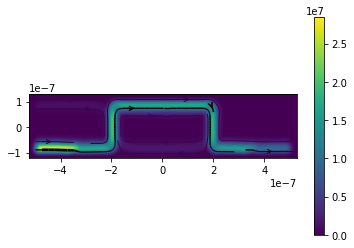

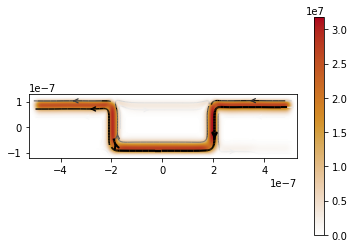

Disorder potential not activated


In [20]:
## To obtain edge states, a strong field is required, in order to be in the high magnetic fiedl regime. 2 T gives edge states, 
## 0.1 T gives normal conduction

J0 = kwant.operator.Current(sys)
wf_left = wfs(0)
wf_right=wfs(1)

#np.append(wf_left,wf_right)
current = sum(J0(p, params = params) for p in wf_left) # to sum over all the lead's mode


current_right=sum(J0(p, params = params) for p in wf_right)


#np.insert(current,1,current_right)


kwant.plotter.current(sys, current, cmap='viridis')





kwant.plotter.current(sys, current_right, )


if(flag==1):
    print('Disorder potential activated')
else:
    print('Disorder potential not activated')

To have clear current plots ypu have to make sure the potential zone does not overlap with the leads 

### Plotting Hall conductance as function of the voltage applied (Fermi level)

In [21]:


print('The field is fixed and equal to ',Bfield)
print('The tip potential is the stairwell potential ')
Ef_min=-0.05
Ef_max=0.11
n_iter=100;

print('The Fermi energy will be shifted from' ,Ef_min, 'to', Ef_max )

Ef_arr=np.linspace(Ef_min,Ef_max,n_iter)

Rxx_Ef=np.zeros([len(Ef_arr),1])
Rxy_Ef=np.zeros([len(Ef_arr),1])

params=dict(Bfield=Bfield, Vg=Vg)

for i,Ef_xy in enumerate(Ef_arr):
        
    try:
        
        s=kwant.smatrix(sys, energy=Ef_xy, params=params)
        
        #conductance matrix from the transmission matrix
        cond = np.array([[s.transmission(i, j) for j in range(n)] for i in range(n)])
        
        cond -= np.diag(cond.sum(axis=0))
        
        cm = s.conductance_matrix()[:-1, :-1]
        
        Rxx = np.linalg.solve(cm, [1, -1, 0, 0, 0])
        print('R hall=',Rxx[4])
        print('R long=',Rxx[3])
        
        Rxx_Ef[i] = Rxx[3]
        
        Rxy_Ef[i] = Rxx[4]
        
        print('iteration',i,'succeeded')
    except:
        print('problem encountered at iteration', i)
        
print(flag)

The field is fixed and equal to  1.82
The tip potential is the stairwell potential 
The Fermi energy will be shifted from -0.05 to 0.11
R hall= -0.9999999999958425
R long= 5.406224563816708e-11
iteration 0 succeeded
R hall= -0.9999999999974256
R long= 3.906895103416479e-10
iteration 1 succeeded
R hall= -0.9999999999986496
R long= 2.2685158119491405e-10
iteration 2 succeeded
R hall= -0.9999999999993927
R long= 7.51672537150214e-11
iteration 3 succeeded
R hall= -0.9999999999992697
R long= 8.299201617296985e-10
iteration 4 succeeded
R hall= -0.9999999999995086
R long= 1.477458274771301e-10
iteration 5 succeeded
R hall= -0.9999999999988585
R long= 1.0986441032332159e-09
iteration 6 succeeded
R hall= -1.0000000000004183
R long= 7.129643102314264e-10
iteration 7 succeeded
R hall= -0.9999999999993283
R long= 2.8345202759887082e-09
iteration 8 succeeded
R hall= -0.99999999999881
R long= 4.664690688488805e-11
iteration 9 succeeded
R hall= -1.0000000000021414
R long= 1.7944191011780752e-09
itera

With this interval of Fermi energy, one should have the following regimes:

In [22]:
Ef_1 = modified_LL[0,2]
Ef_2 = modified_LL[2,0]
Ef_3 = modified_LL[1,2]
Ef_4 = modified_LL[0,0]

print('For ',Ef_min, '< Ef < ', Ef_1, 'partial backscattering regime')
print('     v= -6          v=-2          v=-6')
print('For ',Ef_1, '< Ef < ', Ef_2, 'partial backscattering regime and full backscattering regime')
print('v= -6      v=-2     v=2   v=-2    v=-6')
print('For ',Ef_2, '< Ef < ', Ef_3, 'full backscattering regime')
print('     v= -2          v=2          v=-2')
print('For ',Ef_3, '< Ef < ', Ef_4, 'full backscattering regime and indirect backscattering regime')
print('v= -2      v=2     v=6   v=2    v=-2')
print('For ',Ef_4, '< Ef < ', Ef_max, 'indirect backscattering regime')
print('     v= 2          v=6          v=2')





For  -0.05 < Ef <  -0.04000000000000001 partial backscattering regime
     v= -6          v=-2          v=-6
For  -0.04000000000000001 < Ef <  -0.011541161842040404 partial backscattering regime and full backscattering regime
v= -6      v=-2     v=2   v=-2    v=-6
For  -0.011541161842040404 < Ef <  0.0715411618420404 full backscattering regime
     v= -2          v=2          v=-2
For  0.0715411618420404 < Ef <  0.1 full backscattering regime and indirect backscattering regime
v= -2      v=2     v=6   v=2    v=-2
For  0.1 < Ef <  0.11 indirect backscattering regime
     v= 2          v=6          v=2


### Plotting Hall conductance as function of the magnetic field

In [23]:
#Bmax=2*Ef**2*h_reduced/(9*t**2*a**2*e*1)
Bmin=0;
Bmax=3;                   ## Some Hall features are recovered looking at small foeld regions (Bmax = 1 T or less)
print('The magnetic field will be shifted from', Bmin, 'to', Bmax)
print('The Fermi energy will be constant and set to',Ef)
print('The tip potential is fixed and equal to ', Vg)


## With this method you keep E_f fixed and you sweep the field, so that the LL move.
## If one keeps the field fixed (and the LL) and sweeps Ef, it should be the same.

Bs=np.linspace(Bmin,Bmax,n_iter)

Rxx_B=np.zeros([len(Bs),1])
Rxy_B=np.zeros([len(Bs),1])

for i,Bfield in enumerate(Bs):
        
    try:
        params=dict(Bfield=Bfield, Vg=Vg)
        s=kwant.smatrix(sys, energy=Ef, params=params)
        
        #conductance matrix from the transmission matrix
        cond = np.array([[s.transmission(i, j) for j in range(n)] for i in range(n)])
        
        cond -= np.diag(cond.sum(axis=0))
        
        cm = s.conductance_matrix()[:-1, :-1]
        
        Rxx = np.linalg.solve(cm, [1, -1, 0, 0, 0])
        
        print('R hall = ',Rxx[4])
        print('R long=',Rxx[3])
        Rxx_B[i] = Rxx[3]
        
        Rxy_B[i] = Rxx[4]
        
        print('iteration',i,'succeeded')
    except:
        print('problem encountered at iteration', i)
        


The magnetic field will be shifted from 0 to 3
The Fermi energy will be constant and set to -0.02
The tip potential is fixed and equal to  -0.1
R hall =  0.07359421020796346
R long= 0.8937887963777849
iteration 0 succeeded
R hall =  -0.24958316204598074
R long= 0.9423843682220606
iteration 1 succeeded
R hall =  -0.4861790377250102
R long= 1.0757554997684857
iteration 2 succeeded
R hall =  -0.6361537729086035
R long= 1.2012125049635383
iteration 3 succeeded
R hall =  -0.7397000565971068
R long= 1.0954724316969322
iteration 4 succeeded
R hall =  -0.8328938241827868
R long= 0.6040003273134091
iteration 5 succeeded
R hall =  -0.9528134859976772
R long= 0.0575764133461583
iteration 6 succeeded
R hall =  -1.0400072071822695
R long= 0.16813785666855283
iteration 7 succeeded
R hall =  -1.0318491602596498
R long= 0.7300099022627614
iteration 8 succeeded
R hall =  -1.009725880737495
R long= 0.5687929888073909
iteration 9 succeeded
R hall =  -0.9985314865810451
R long= 0.01486671646501282
iterati

### Plotting Hall conductivity as function of local potential (tip potential)

In [ ]:
print('The field is fixed and equal to', Bfield)
print('The Fermi level is fixed and equal to', Ef)

Vg_min=-0.17
Vg_max=0.09
n_iter_Vg=100;
print('We will shift the tip potential from', Vg_min, 'to', Vg_max)
print('We should have crossing with the first positive and negative LL and 0th LL')

Vg_arr=np.linspace(Vg_min,Vg_max,n_iter_Vg)
Rxx_Vg=np.zeros([len(Vg_arr),1])
Rxy_Vg=np.zeros([len(Vg_arr),1])


for i,Vg in enumerate(Vg_arr):
        
    try:
        params=dict(Bfield=Bfield, Vg=Vg)
        s=kwant.smatrix(sys, energy=Ef, params=params)
        
        #conductance matrix from the transmission matrix
        cond = np.array([[s.transmission(i, j) for j in range(n)] for i in range(n)])
        
        cond -= np.diag(cond.sum(axis=0))
        
        cm = s.conductance_matrix()[:-1, :-1]
        
        Rxx = np.linalg.solve(cm, [1, -1, 0, 0, 0])
        
        print('R hall = ',Rxx[4])
        print('R long=',Rxx[3])
        Rxx_Vg[i] = Rxx[3]
        
        Rxy_Vg[i] = Rxx[4]
        
        print('iteration',i,'succeeded')
    except:
        print('problem encountered at iteration', i)

print(flag)

The field is fixed and equal to 3.0
The Fermi level is fixed and equal to -0.02
We will shift the tip potential from -0.17 to 0.09
We should have crossing with the first positive and negative LL and 0th LL
R hall =  -1.0001239716176638
R long= 1.0195241713770549
iteration 0 succeeded
R hall =  -1.0002904591368573
R long= 0.6634822522325496
iteration 1 succeeded
R hall =  -0.9999729604430166
R long= 0.006932961267030967
iteration 2 succeeded
R hall =  -1.0001102456957147
R long= 0.4089664842251967
iteration 3 succeeded
R hall =  -1.0001887468242285
R long= 0.18909111714938992
iteration 4 succeeded
R hall =  -0.9999829669703245
R long= 0.005909405148241661
iteration 5 succeeded
R hall =  -1.0000855421647932
R long= 0.09568587548036289
iteration 6 succeeded
R hall =  -1.0000918490602517
R long= 0.04339605158879757
iteration 7 succeeded
R hall =  -1.0000041395124462
R long= 0.00431816704645563
iteration 8 succeeded
R hall =  -1.0000169521910562
R long= 0.0017734853136941494
iteration 9 suc

With these values of Vg, one should have crossing of the modified LL for these values of tip potential:

In [ ]:
Vg_minus_1 = En_plot_minus[1]-Ef
Vg_0 = En_plot_plus[0]-Ef
Vg_plus_1 = En_plot_plus[1] - Ef

print('Vg = ', Vg_minus_1, 'for the -1 LL')
print('Vg = ', Vg_0, 'for the 0th LL')
print('Vg = ', Vg_plus_1, 'for the 1st LL')

Since the longitudinal resistance changes depending on how many edge states are bakcscattered, these should be the values for which peaks in the longitudinal resistance should appear

#### Hall resistivity vs magnetic field

In [ ]:

plt.figure()
plt.plot(Bs, Rxy_B, label = 'Hall resistivity')
plt.plot(Bs, Rxx_B, label = 'Longitudinal resistivity')
plt.legend()

plt.xlabel('Magnetic field (T)')
plt.ylabel('Resistivity (h/2e²)')
plt.title("Hall resistivity vs magnetic field")

plt.show()

#### Hall resistivity vs Fermi Energy

In [ ]:

plt.figure()
plt.plot(Ef_arr, Rxy_Ef, label = 'Hall resistivity')
plt.legend()

plt.xlabel('Fermi Energy (eV)')
plt.ylabel('Resistivity (h/2e²)')
plt.title("Hall resistivity vs Fermi energy")

plt.show()

#### Longitudinal resistivity vs Fermi energy (with non-zero tip potential)

In [ ]:
indices=np.where(Rxx_Ef > 10)
Rxx_Ef[indices]=0

plt.figure()
plt.plot(Ef_arr, Rxx_Ef, label = 'Longitudinal resistivity')
plt.legend()

plt.xlabel('Fermi Energy (eV)')
plt.ylabel('Resistivity (h/2e²)')
plt.title("Longitudinal resistivity vs Fermi energy")

plt.show()

#### Hall resistivity vs tip potential

In [ ]:
plt.figure()
#plt.plot(Vg_arr, Rxy_Vg, label = 'Hall resistivity')
plt.plot(Vg_arr,Rxx_Vg, label = 'Longitudinal resistivity')

plt.legend()

plt.xlabel('Tip potential (V)')
plt.ylabel('Resistivity (h/2e²)')
#plt.text(-0.1, 0.98, "B = 10 T, Ef = 0.05 eV")
plt.title("Hall resistivity vs tip potential")

#plt.axvline(Vg_minus_1, color = 'green')
#plt.axvline(Vg_0, color = 'green')
#plt.axvline(Vg_plus_1, color = 'green')

plt.show()

It seems like the transitions in the Hall resistance occur when Ef = LL at the edges, so R hall should not be influenced by the swiping of the potential. For these values of Ef and B, Rhall=1 (see figure Rh vs B) which is indeed what we get

About the longitudinal resistance, a small peak is observed for Vg_minus_1 (crossing with LL -1), no peak is observed for Vg_0 (crossing with 0th LL) and a series of peaks is observed in the surroundings of Vg_plus_1 (crossing with first LL) anyway I cannot explain the other peaks in this region. No peak is observed for Vg_0 since for the interval Vg_0 < V < Vg_plus_1 you have the same filling factor all the device. 

#### Conductivity vs magnetic field

In [ ]:


plt.figure()

G_xy_B=np.power(Rxy_B,-1)
plt.plot(Bs[3:],G_xy_B[3:])


G_j=np.zeros(len(Ef_arr))
for j in range (1,11,2):
    G_j=j*np.ones(len(Ef_arr))
    if (j==1):
        plt.plot(Bs,G_j,'b-.', label ="v = +- 2")
    elif(j==3):
        plt.plot(Bs,G_j,'r-.', label="v = +- 6")
    elif(j==5):
        plt.plot(Bs,G_j,'y-.',  label = "v = +- 10")
    elif(j==7):
        plt.plot(Bs,G_j,'g-.',  label = "v = +- 14")
  
    


plt.xlabel('Magnetic field (T)')
plt.ylabel('Conductivity (h/2e²)^-1')
plt.title("Hall conductivity vs magnetic field")
#plt.text(2, 10, "Ef = 0.05 eV, Vg = 0 V")
plt.legend(loc ="upper right")

plt.show()


Since the conductivity is defined in units of hbar/2e^2 the values of the filling factors which can be retrieved from the plot have to be multiplied by 2. Therefore one gets the usual succession of filling factors in graphene so 2,6,10 etc. with the spins and valley degeneracy, evein if the spin has not been explicitly considered in the calculations. The step for v=14 is anyway missing (crossing of third LL, n=3).

#### Conductivity vs Fermi energy

In [ ]:

plt.figure()

G_xy_Ef=np.power(Rxy_Ef,-1)
plt.plot(Ef_arr[8:42],G_xy_Ef[8:42])


G_j=np.zeros(len(Ef_arr))
for j in range (1,11,2):
    G_plus_j=j*np.ones(len(Ef_arr))
    G_minus_j=-j*np.ones(len(Ef_arr))
    if (j==1):
         plt.plot(Ef_arr,G_plus_j,'b-.', label="v = +- 2")
         plt.plot(Ef_arr,G_minus_j,'b-.')
    elif(j==3):
        plt.plot(Ef_arr,G_plus_j,'r-.', label="v = +- 6")
        plt.plot(Ef_arr,G_minus_j,'r-.')
    elif(j==5):
        plt.plot(Ef_arr,G_plus_j,'y-.', label = "v = +- 10")
        plt.plot(Ef_arr,G_minus_j,'y-.')
    elif(j==7):
        plt.plot(Ef_arr,G_plus_j,'g-.', label = "v = +- 14")
        plt.plot(Ef_arr,G_minus_j,'g-.')
    
    
#print(Rxy_Ef)
#print(G_xy_Ef)

#for i in range (num_LL):
#    plt.axvline(LL_pot_plus[i],color = 'green',linestyle = '-.')
#    plt.axvline(LL_pot_minus[i],color = 'green',linestyle = '-.')
#    plt.axvline(En_plus[i],color = 'black',linestyle = '-.')
#    plt.axvline(En_minus[i], color = 'black',linestyle = '-.')





plt.xlabel('Fermi energy (eV)')
plt.ylabel('Conductivity (h/2e²)^-1')
plt.title("Hall conductivity vs Fermi energy")
#plt.text(-0.3, 15, "B = 1.82 T, Vg = 0 V")
plt.legend(loc ="lower right")

plt.show()

#### Longitudinal conductivity vs tip potential

In [ ]:

plt.figure()

G_xx_Vg=np.power(Rxx_Vg,-1)
plt.plot(Vg_arr[2:],G_xx_Vg[2:])


plt.xlabel('Tip potential (V)')
plt.ylabel('Longitudinal Conductivity (h/2e²)^-1')
#plt.text(0.05, 1.015, "B = 10 T, Ef = 0.05 eV")
plt.title("Longitudinal conductivity vs tip potential")

plt.show()

In this case clear steps of 2G0 are observed also for high filling factors but I don't really know to which transition they can be associated, since theoretically we have defined just 5 LL. Anyway, sweeping the gate voltage with opposite signs, the same fearures are obtained but with opposite signs, associated to the holes LL.

In [ ]:
#print(Vg_arr)
print (Ef_arr[46])

### Open issues
#### - 2G0 steps (?)
#### - Longitudinal resistivity null
#### - Plateaus associated with transitions out of the 5 LL defined

In [ ]:
np.where(Rxx_Vg < 1e-08)
print(Rxx_Vg[59])
print(Vg_arr[59])


In [ ]:
print(current)
print(current_right)